## Classification_matrics

- 確率値の校正
- logLoss (balanced and imbalanced)
- confusion matrix(混合行列)
- TPR，FNR，TNR，FPR（誤ってposと判定した：negに対する比率）
- accuracy(正解率), precision(適合率), recall(再現率), F値
- roc curve and auc(area under curve)
- pr curve and ap(average precision)
- normalized entoropy(from facebook paper)

In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from sklearn import metrics
import seaborn as sns

#### Data loading

In [37]:
train = pd.read_csv('created_data/train.csv',encoding='cp932')
valid = pd.read_csv('created_data/valid.csv',encoding='cp932')
test = pd.read_csv('created_data/test.csv',encoding='cp932')

In [38]:
xtest = test.drop(['id','target'],axis=1).values
ytest = test['target'].values

#### Model loading
- 今回は均一データに対する学習モデルを採用し，「確率値」と「LogLoss」の校正前後での変動を評価する．

In [39]:
fn_model01 = 'model_balanced.sav'
model = pickle.load(open(fn_model01, 'rb'))

In [40]:
beta = 0.264990133076962

#### （疑問）あれ？lightgbmのpredict(proba:binary)はラベル{0,1}のどちらの確率を算出しているんだっけ？
- おそらく，{0,1}の1をposとし，割合を算出していると思う．のでthreshより高いほうを1とするのが正しい
- http://data-analysis-stats.jp/2019/11/13/lightgbm%E3%81%AE%E8%A7%A3%E8%AA%AC/

※ちなみに今回の検証では，少数クラスが1であり，クラス0をアンダーサンプルしている．  
つまり，negであるクラス0をデータカットし，posであるクラス1の確率を算出しているため，negのデータ割合を使い，posの確率を校正する正しい計算が行われている．

#### (1)Calculate "prob_s" and calibrated prob "prob_c"

In [48]:
probe_s = model.predict(xtest)
probe_c = (beta*probe_s) / ((beta*probe_s) - probe_s + 1)

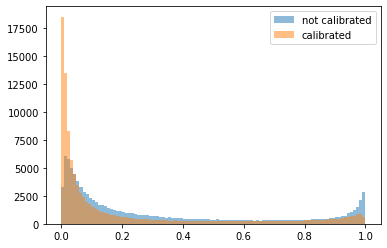

not calib 0.321521103234933 calib 0.2033911578923052


In [56]:
plt.figure()
plt.hist(probe_s,label='not calibrated',bins=100,alpha=0.5)
plt.hist(probe_c,label='calibrated',bins=100,alpha=0.5)
plt.legend()
plt.show()
print('not calib',np.mean(probe_s),'calib',np.mean(probe_c))

#### (2) compare LogLoss

In [61]:
def logloss(label,proba):#label(1)の確率が算出されている．
    
    N = len(label)
    
    proba1 = proba[label==1]
    sum1 = np.sum(np.log(proba1))
    
    label0 = label[label==0]
    proba0 = 1 - proba[label==0]
    sum0 = np.sum(np.log(proba0))
    
    return -(sum1+sum0)/N

In [63]:
print('not calib',logloss(ytest,probe_s))
print('calib',logloss(ytest,probe_c))

not calib 0.29752308704305264
calib 0.23254721655714736


これって校正後が下がるのが正しいのか？

#### (3)confusion matrix（視点が事実）

In [71]:
thresh = 0.2 #if proba >=0.2 label=1 else label=0
n = len(probe_c)
pred_label = np.zeros(n)
for i in range(n):
    if probe_c[i] > thresh:
        pred_label[i] = 1
    else:
        pred_label[i] = 0

※(pos = 1, neg = 0とする)  

In [93]:
p = pred_label[ytest==1]
n = pred_label[ytest==0]

tp = p[p==1].shape[0]
fn = p[p==0].shape[0]
tn = n[n==0].shape[0]
fp = n[n==1].shape[0]
print(tn,fp,fn,tp)

69872 9137 2761 18230


In [98]:
cm= metrics.confusion_matrix(ytest,pred_label)
tn, fp, fn, tp = cm.ravel()
print(tn,fp,fn,tp)

69872 9137 2761 18230


binary{0,1}の場合，sklearn.metrics.confusion_matrix()は，{1}をposとした上記コードの対応関係を持っているはず．

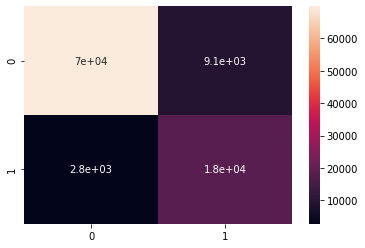

In [105]:
sns.heatmap(cm,annot=True,label=['neg','pos'])

#### (4)TPR，FNR，TNR，FPR（視点が予測）

In [107]:
tpr = tp / (tp + fn)
fnr = fn / (tp + fn)
tnr = tn / (tn + fp)
fpr = fp / (tn + fp)

#### (5) other metrics

In [113]:
acc = (tp + tn) / (tp + fn + fp + tn)
precision = tp / (tp + fp)
recall = tp / (tp + fn)
F = "wait"
print(acc, precision, recall, F)

0.88102 0.6661307414038806 0.868467438425992 wait


#### (6) ROC curve (TPR vs FPR)
- 正しくposと言った割合 vs 誤ってposと言った割合：pos negの双方のデータを考慮

In [121]:
FPR, TPR, Thresh = metrics.roc_curve(ytest,probe_c)
ROC_AUC = metrics.roc_auc_score(ytest,probe_c)

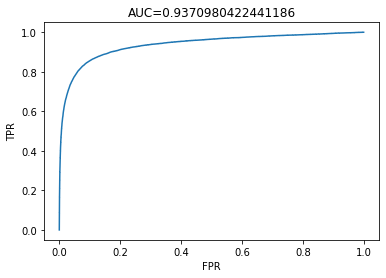

In [122]:
plt.figure()
plt.title('AUC=%s'%ROC_AUC )
plt.plot(FPR, TPR)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

#### (7) Presison - Recall curve 

In [128]:
precision, recall, thresholds = metrics.precision_recall_curve(ytest,probe_c,pos_label=1)
AP = metrics.average_precision_score(ytest,probe_c,pos_label=1) # Average precision

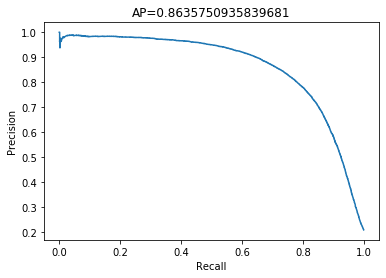

In [129]:
plt.figure()
plt.title('AP=%s'%AP )
plt.plot(recall,precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

※AP < AUCですね．APの方が不均一化における評価として厳密ですね．

#### (8) Normalized Entropy

In [135]:
def NE(label,proba):#label(1)の確率が算出されている．
    #logloss
    N = len(label)
    proba1 = proba[label==1]
    sum1 = np.sum(np.log(proba1))
    
    label0 = label[label==0]
    proba0 = 1 - proba[label==0]
    sum0 = np.sum(np.log(proba0))
    
    logloss = -(sum1+sum0)/N
    
    #NE
    p = np.mean(proba)
    deno = - ( p * np.log(p) + (1-p) * np.log(1 - p) )
    return logloss/deno

In [137]:
NE = NE(ytest,probe_c)

#### 参照  
- https://pompom168.hatenablog.com/entry/2019/04/11/080000
- https://pompom168.hatenablog.com/entry/2019/07/22/113433
- https://research.fb.com/wp-content/uploads/2016/11/practical-lessons-from-predicting-clicks-on-ads-at-facebook.pdf